In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled.")
    except RuntimeError as e:
        print(e)

import warnings
warnings.filterwarnings('ignore')

Memory growth enabled.


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS  = 3
EPOCHS = 25

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True
)


Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

501

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].numpy())

(32, 256, 256, 3)
[6 0 7 4 7 7 4 7 0 5 7 6 0 7 0 0 4 9 5 9 7 3 7 7 1 7 1 4 0 0 4 2]
[[[101.  89.  93.]
  [121. 109. 113.]
  [117. 105. 109.]
  ...
  [123. 114. 119.]
  [165. 156. 161.]
  [154. 145. 150.]]

 [[124. 112. 116.]
  [127. 115. 119.]
  [113. 101. 105.]
  ...
  [139. 130. 135.]
  [158. 149. 154.]
  [134. 125. 130.]]

 [[107.  95.  99.]
  [128. 116. 120.]
  [135. 123. 127.]
  ...
  [145. 136. 141.]
  [149. 140. 145.]
  [128. 119. 124.]]

 ...

 [[144. 132. 136.]
  [112. 100. 104.]
  [143. 131. 135.]
  ...
  [155. 144. 148.]
  [138. 127. 131.]
  [123. 112. 116.]]

 [[119. 107. 111.]
  [114. 102. 106.]
  [108.  96. 100.]
  ...
  [127. 116. 120.]
  [112. 101. 105.]
  [117. 106. 110.]]

 [[114. 102. 106.]
  [104.  92.  96.]
  [111.  99. 103.]
  ...
  [137. 126. 130.]
  [129. 118. 122.]
  [145. 134. 138.]]]


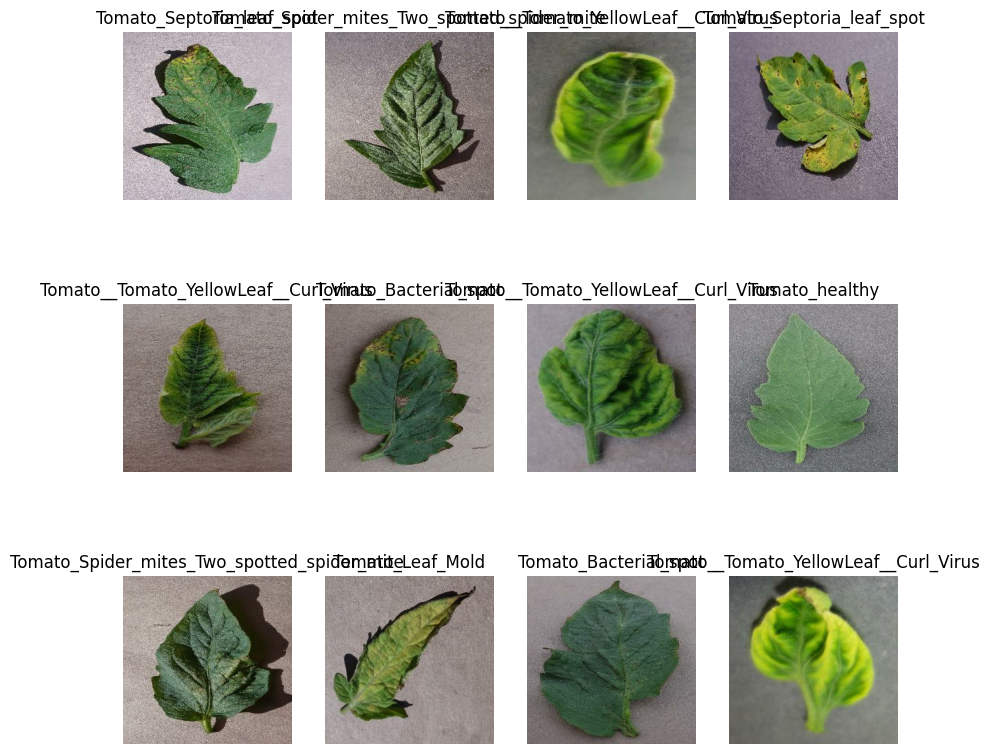

In [8]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [9]:
def get_dataset_partitions(ds, train_split = 0.8, val_split = 0.1, shuffle = True, shuffle_size = 10000):

    ds_size = int(len(ds))/1.6

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 5)        

    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size).take(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [10]:
len(train_ds), len(val_ds), len(test_ds), len(dataset)/1.6

(250, 31, 31, 313.125)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescaling = tf.keras.Sequential([
    layers.Rescaling(1.0/255),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomFlip('horizontal_and_vertical')
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'],
)

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data = val_ds,
    verbose=1,
    epochs = EPOCHS
)

Epoch 1/25
250/250 [==============================] - 165s 470ms/step - loss: 1.9083 - accuracy: 0.3100 - val_loss: 1.7305 - val_accuracy: 0.3851
Epoch 2/25
250/250 [==============================] - 68s 270ms/step - loss: 1.4837 - accuracy: 0.4809 - val_loss: 1.6308 - val_accuracy: 0.4627
Epoch 3/25
250/250 [==============================] - 56s 224ms/step - loss: 1.0143 - accuracy: 0.6415 - val_loss: 1.1719 - val_accuracy: 0.5978
Epoch 4/25
250/250 [==============================] - 55s 219ms/step - loss: 0.7547 - accuracy: 0.7335 - val_loss: 1.1299 - val_accuracy: 0.6321
Epoch 5/25
250/250 [==============================] - 55s 221ms/step - loss: 0.6636 - accuracy: 0.7639 - val_loss: 0.9064 - val_accuracy: 0.7127
Epoch 6/25
250/250 [==============================] - 55s 221ms/step - loss: 0.5803 - accuracy: 0.7849 - val_loss: 0.6932 - val_accuracy: 0.7450
Epoch 7/25
250/250 [==============================] - 55s 222ms/step - loss: 0.5122 - accuracy: 0.8205 - val_loss: 1.2882 - val_a

In [18]:
scores = model.evaluate(test_ds)

31/31 [==============================] - 53s 48ms/step - loss: 0.3650 - accuracy: 0.8821


In [19]:
history

In [20]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 250}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

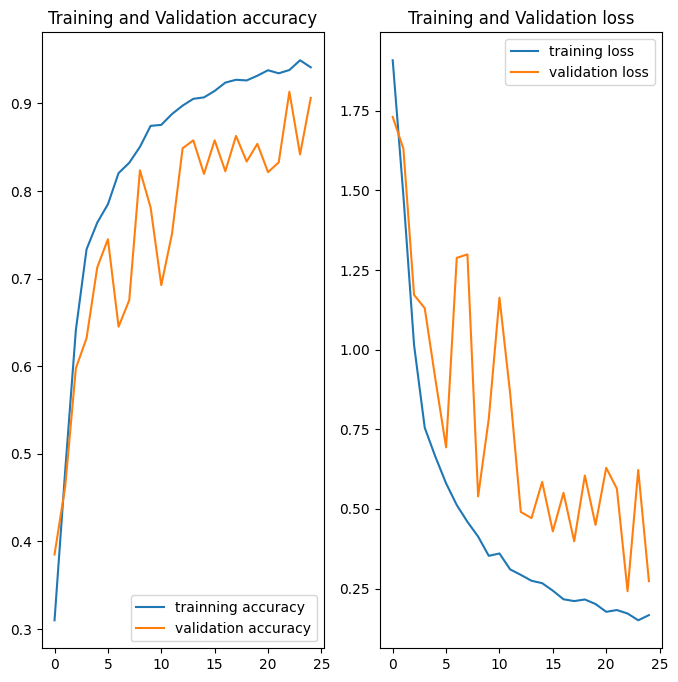

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label= 'trainning accuracy')
plt.plot(range(EPOCHS), val_accuracy, label = 'validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'lower right')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label = 'validation loss')
plt.legend(loc= 'upper right')
plt.title('Training and Validation loss')

Actual label:  Tomato_Leaf_Mold
1/1 [==============================] - 1s 556ms/step
Predicted label:  Tomato_Septoria_leaf_spot


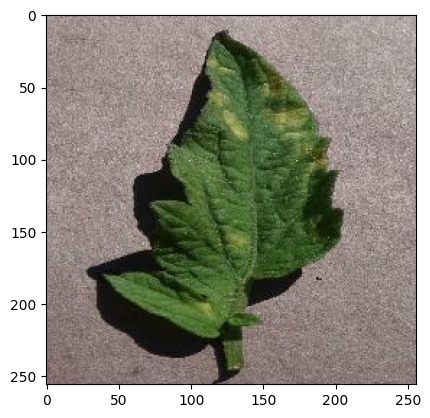

In [24]:
import numpy as np

for image_batch, label_batch in test_ds.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    image_label = class_names[label_batch[0].numpy()]
    print('Actual label: ', image_label)

    batch_prediction = model.predict(image_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]
    print('Predicted label: ', predicted_label)

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_label = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)

    return predicted_label, confidence

1/1 [==============================] - 0s 22ms/step


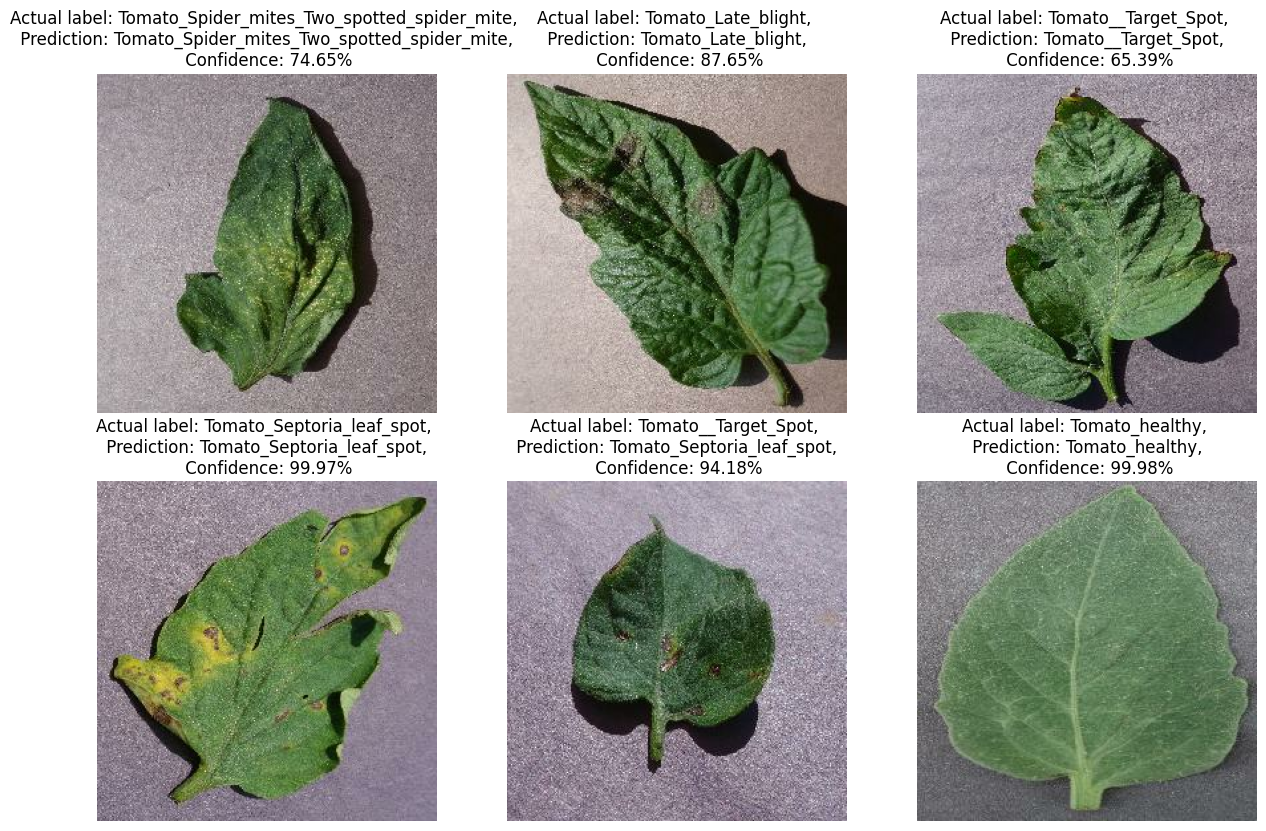

In [26]:
plt.figure(figsize=(15,15))

for images, label in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')

        actual_label = class_names[label[i]]
        predicted_label, confidence = predict(model, images[i].numpy())

        plt.title(f'Actual label: {actual_label}, \n Prediction: {predicted_label}, \n Confidence: {confidence}%')

In [27]:
import os
model_version = len(os.listdir('../saved_models'))
model.save(f'../saved_models/{model_version}')

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


In [28]:
model.save("../tomatoes.h5")

In [59]:
model.save('../model.keras')